# Markowitz por fuerza bruta 74.000 fondos de inversión

Objetivo: realizar una propuesta de cartera eficiente sobre 74.000 fondos de inversión. 





In [2]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import *
import random
from time import time
from matplotlib import pyplot as plt

## Cargamos los datos y los homogeneizamos

In [3]:
def cargar_ficheros():
    
    onlyfiles = [f for f in listdir('Datos') if isfile(join('Datos', f))]

    datos = []

    for fichero in onlyfiles:

        
        df = pd.read_csv(join('Datos', fichero))    
        datos.append(df)

    datos = pd.concat(datos)
    return datos

In [4]:
def comprobar_homogeneizacion(datos):

    

    long_fechas_unicas = datos.date.unique().shape[0]
    long_isin_unicos = datos.iloc[:,2].unique().shape[0]

    if (long_fechas_unicas * long_isin_unicos == datos.shape[1]) == True:
        print("Los activos están homogeneizados")
        return True
    else:
        print("Los activos NO están homogeneizados")
        return False    
    

In [5]:
def extraccion_datos(isin, datos):
    
    
    df_intermedio = datos.loc[datos["isin"]==isin,:]

    # Genero un nuevo DF solo con los datos que nos interesan:
    
    nuevo_df = pd.DataFrame(df_intermedio, columns=["date","nav"])
    
    # Hay isins con fechas repetidas
    nuevo_df = nuevo_df.groupby('date').first().reset_index()      
    
    nuevo_df.index = nuevo_df.date  
    nuevo_df.index = pd.to_datetime(nuevo_df.index)    
    del nuevo_df["date"]
    nuevo_df.columns = [isin]
    
    return nuevo_df

In [6]:
def homogeizar(datos):

    # El set de datos tiene un año de duración y 74.000 fondos de inversión
    
    
    lista_isin = datos.iloc[:,2].unique()
    fechas_posibles = datos.date.unique()
    fechas_posibles.sort()
    fechas_posibles = pd.date_range(fechas_posibles[0], fechas_posibles[-1], freq=BDay())
    datos_ordenados = pd.DataFrame(columns=[""], index = fechas_posibles) 

    for isin in lista_isin:

        print(isin)
        isin_extraido = extraccion_datos(isin, datos)

        if (isin_extraido.shape[0] > fechas_posibles.shape[0]*0.7):

            datos_ordenados = pd.concat([datos_ordenados, isin_extraido], axis=1) # alternativa datos_ordenados = datos_ordenados.join(isin_extraido)

    datos_ordenados = datos_ordenados.drop(columns='')

    
    dias_eliminar = ~(datos_ordenados.isna().sum(axis=1) > datos_ordenados.shape[1]*0.9)
    datos_ordenados = datos_ordenados.loc[dias_eliminar,:]


    datos_ordenados = datos_ordenados.fillna(method='ffill')

    
    datos_ordenados = datos_ordenados.fillna(method='bfill')

    datos_ordenados.to_pickle("datos_ordenados.pkl")     
    
    return datos_ordenados

In [7]:
# Cargar datos
try:
    datos_ordenados = pd.read_pickle("datos_ordenados.pkl")

except:
    datos = cargar_ficheros()
    comprobacion = comprobar_homogeneizacion(datos)

    if comprobacion == False:
        datos_ordenados = homogeizar(datos)

print(datos_ordenados.shape)
print("En ningún caso se podrá trabajar con menos de 55.000 fondos de inversión")
print("")
datos_ordenados.head()

(243, 58466)
En ningún caso se podrá trabajar con menos de 55.000 fondos de inversión



,AT0000A139C4,DE000A1C4DQ3,DK0016260003,HK0000098829,HK0000162849,HK0000176732,HK0000194255,HK0000194263,HK0000220001,HK0000220126,...,LU2041044764,LU2065166824,LU2070009225,LU2070343475,LU2075911490,LU2091570395,LU2091609433,LU2096785782,LU2097341684,LU2097343110
2020-01-03,1092.43,1383.79,266.17,10.21,8.32,98.03,90.14,106.19,16.00,13.02,...,9.67,10.2324,100.8316,10.41,101.01,10.0,100.0,100.0,100.0,100.0
2020-01-06,1092.43,1379.76,266.48,10.22,8.31,98.13,90.12,106.32,15.91,12.94,...,9.59,10.1698,100.9713,10.32,100.93,10.0,100.0,100.0,100.0,100.0
2020-01-07,1090.98,1378.96,266.70,10.23,8.32,98.15,90.23,106.36,16.04,13.06,...,9.60,10.1945,101.0196,10.33,100.91,10.0,100.0,100.0,100.0,100.0
2020-01-08,1093.49,1384.76,266.81,10.22,8.32,98.16,90.24,106.25,15.91,12.94,...,9.62,10.2297,101.0289,10.35,100.96,10.0,100.0,100.0,100.0,100.0
2020-01-09,1094.23,1387.90,265.69,10.23,8.34,98.18,90.49,106.34,16.08,13.09,...,9.68,10.2909,101.0115,10.41,101.03,10.0,100.0,100.0,100.0,100.0


## Analizamos cómo generar los pesos de las carteras

In [8]:
# Experimento 1)
# Queremos generar carteras, con activos seleccionados aleatoriamente, y su peso asociado


num_activos = datos_ordenados.shape[1]
simulaciones = 50000


aleatorios = np.random.randint(low=1, high=100, size=num_activos * simulaciones)
aleatorios = aleatorios.reshape((simulaciones, num_activos))


umbral = 98

aleatorios[aleatorios<umbral] = 0
aleatorios[aleatorios>=umbral] = 1

print(aleatorios.sum(axis=1)) 
print("")


[1184 1190 1231 ... 1187 1156 1170]



In [ ]:
# Experimento 2)


aleatorios = pd.DataFrame(aleatorios)
aleatorios.to_pickle("aleatorios.pkl") 

start_time = time()

# Cargar el DataFrame desde el archivo PKL
aleatorios_recuperados = pd.read_pickle("aleatorios.pkl")

elapsed_time = time() - start_time
print(elapsed_time)
print("")
print("")


In [10]:
# Experimento 3)

num_activos = datos_ordenados.shape[1]
simulaciones = 50000

# Generamos números aleatorios
start_time = time()
aleatorios = np.random.randint(low=1, high=100, size=num_activos * simulaciones)
aleatorios = aleatorios.reshape((simulaciones, num_activos))
elapsed_time = time() - start_time
print(elapsed_time)

# Reordenamos los existentes
start_time = time()
np.random.shuffle(np.transpose(aleatorios))
elapsed_time = time() - start_time
print(elapsed_time)
print("")


18.05709171295166
42.541566133499146



In [11]:
# Experimento 1B:

# Cada simulación, cada cartera, debe tener entre 1 y 20 activos

    
print("")
start_time = time()

aleatorios = np.random.random((simulaciones,num_activos))

umbral = 0.9998
aleatorios[aleatorios<umbral] = 0
aleatorios[aleatorios>=umbral] = 1

suma_filas = aleatorios.sum(axis=1)
print(suma_filas[:500]) 

# Calculo el porcentaje de filas con más de 20 activos
filas_mayor_20 = np.sum(suma_filas > 20)
porcentaje_mayor_20 = (filas_mayor_20 / simulaciones) * 100
print("")
print(f"Porcentaje de filas con suma mayor a 20: {porcentaje_mayor_20:.2f}%")

# Calculo el porcentaje de filas con 0 activos
filas_con_cero = np.sum(suma_filas == 0)
porcentaje_igual_cero = (filas_con_cero / simulaciones) * 100
print("")
print(f"Porcentaje de filas con cero activos: {porcentaje_igual_cero:.2f}%")

elapsed_time = time() - start_time
print("")
print(elapsed_time)
print("")





[19. 11.  7. 11. 13. 10. 15. 14. 13. 13. 17. 10. 14.  5. 12. 12. 15. 10.
  7. 12. 11.  5. 13. 15.  9. 11. 12.  8.  4. 11. 10.  8. 11.  8. 18.  9.
 10. 13. 15.  9. 14. 10. 10. 13. 18.  8.  6.  7. 14.  9. 13. 10. 11.  7.
  7. 14. 10. 12. 17. 16. 15. 15. 10. 14. 19.  9. 13. 10. 13.  9.  7. 10.
 13. 13. 13. 10. 10.  8. 12.  9. 21. 15. 13. 14. 11.  8.  9. 16. 11. 15.
 12.  8.  8. 15. 14.  4. 14. 16.  6. 14. 13. 12. 14. 11. 15. 10.  7.  6.
 18. 16. 17. 12. 12. 10. 20. 14. 12. 15. 13.  9.  8.  9. 18. 13. 13. 14.
 10. 12. 12. 13. 12.  9. 14. 11. 15. 10. 12. 12. 12. 15. 14. 15. 14. 22.
 15. 10. 13.  6.  4. 12. 12. 15. 14. 12. 12. 20. 11. 13.  9.  6. 11. 11.
 18.  8. 19. 14. 13. 14.  7. 16. 14. 10. 16. 17.  9.  7. 12. 15.  7. 13.
  8. 12.  8. 18. 13. 10. 18. 12. 10. 14. 10.  6. 14. 14. 15. 10.  8.  8.
 10.  9. 14. 14.  9.  7. 16. 20.  9. 16. 13. 11. 22.  7. 13. 10.  8.  8.
 11. 10.  5.  4.  8. 13. 15.  7. 10. 16. 13. 11.  5. 20. 11.  8. 12. 13.
  9. 13. 12. 12. 20. 18. 21. 15.  9.  9. 10. 11. 1

## Calculamos la frontera de Markowitz

**Programamos una función a la que llamar para generar los pesos**

In [ ]:
def generador_pesos(datos_ordenados, simulaciones = 10000):
    
   
    num_activos = datos_ordenados.shape[1]
    aleatorios = np.random.random((simulaciones,num_activos))

    umbral = 0.9998
    aleatorios[aleatorios<umbral] = 0

    
    seleccion = ~(aleatorios.sum(axis=1) == 0)
    aleatorios = aleatorios[seleccion,:]

    
    aleatorios[aleatorios!=0] = (aleatorios[aleatorios!=0] - umbral) * 10000

    for sim in range(aleatorios.shape[0]):

        vector_pesos = aleatorios[sim,:]    
        posiciones = list(set(np.where(vector_pesos!=0)[0]))

        # Obtenemos el órden 
        random.shuffle(posiciones)

        peso = 0
        for pos in posiciones:
            
            if peso < 1:
                peso += aleatorios[sim, pos]

                if peso > 1:            
                    exceso = peso - 1
                    aleatorios[sim, pos] = aleatorios[sim, pos] - exceso
                    peso = 1            

            elif peso == 1:
                aleatorios[sim, pos] = 0
    
 
    
    return aleatorios
    

In [ ]:
def frontera_markowitz(num_simulaciones=100000):

   
    try:
        datos_ordenados = pd.read_pickle("datos_ordenados.pkl")

    except:
        datos = cargar_ficheros()
        comprobacion = comprobar_homogeneizacion(datos)

        if comprobacion == False:
            datos_ordenados = homogeizar(datos)

    
    eficiencia_inicial = -100
    plt.figure(figsize=(20,15))    

    
    rent_activos = np.log(datos_ordenados).diff() 
    rent_activos = rent_activos.iloc[1:,:]

   
    matriz_covarianzas = rent_activos.cov()
    matriz_covarianzas = matriz_covarianzas.to_numpy(dtype='float') 

    
    precio_inicial = datos_ordenados.iloc[0,:]
    precio_final = datos_ordenados.iloc[-1,:]

    rentabilidad_diaria = np.log(precio_final / precio_inicial) / datos_ordenados.shape[0]
    
   
    num_bloques = int(np.ceil(num_simulaciones/10000))
    
    for bloque in range(num_bloques):

        
        matriz_pesos = generador_pesos(datos_ordenados, simulaciones = 10000)

        
        auxiliar = rentabilidad_diaria.values * matriz_pesos
        rentabilidad_carteras = auxiliar.sum(axis=1)

        
        auxiliar = np.dot(matriz_pesos, matriz_covarianzas) 
        riesgo_carteras = pow((auxiliar * matriz_pesos).sum(axis=1), 0.5)

       
        filtro_riesgo = riesgo_carteras < np.percentile(riesgo_carteras, 99)
        riesgo_carteras = riesgo_carteras[filtro_riesgo]
        rentabilidad_carteras = rentabilidad_carteras[filtro_riesgo]

        filtro_rentabilidad = rentabilidad_carteras > np.percentile(rentabilidad_carteras, 1)
        riesgo_carteras = riesgo_carteras[filtro_rentabilidad]
        rentabilidad_carteras = rentabilidad_carteras[filtro_rentabilidad]

      
        posiciones_0entre0 = (rentabilidad_carteras==0) * (riesgo_carteras==0)
        riesgo_carteras[posiciones_0entre0] = 0.0000001
        eficiencia_carteras = rentabilidad_carteras / riesgo_carteras

   
        max_eficiencia = max(eficiencia_carteras)

        if max_eficiencia > eficiencia_inicial:

            posicion_cartera_eficiente = np.where(eficiencia_carteras == max_eficiencia)[0]
            cartera_eficiente = matriz_pesos[posicion_cartera_eficiente,:]    
            posicion_activos_eficientes = np.where(cartera_eficiente!=0)

            peso_activos_eficientes = cartera_eficiente[posicion_activos_eficientes]            
            isin_activos_eficientes = rent_activos.columns.values[posicion_activos_eficientes[1]]            
            eficiencia_inicial = max_eficiencia

        
        if (bloque + 1) % 50 == 0:
            print(f'Iteracion {bloque+1} de {num_bloques}')
        plt.plot(riesgo_carteras,rentabilidad_carteras, 'o', color="b")


    plt.xlabel("Riesgo")
    plt.ylabel("Rentabilidad")

    scale_factor = 3
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor/2, ymax * scale_factor/2)
    plt.savefig('frontera_markowitz.png')

    return isin_activos_eficientes, peso_activos_eficientes, max_eficiencia

Iteracion 50 de 500
Iteracion 100 de 500
Iteracion 150 de 500
Iteracion 200 de 500
Iteracion 250 de 500
Iteracion 300 de 500
Iteracion 350 de 500
Iteracion 400 de 500
Iteracion 450 de 500
Iteracion 500 de 500
['LU0690374961']
[1.]
0.9492998646004749

85589.97326278687


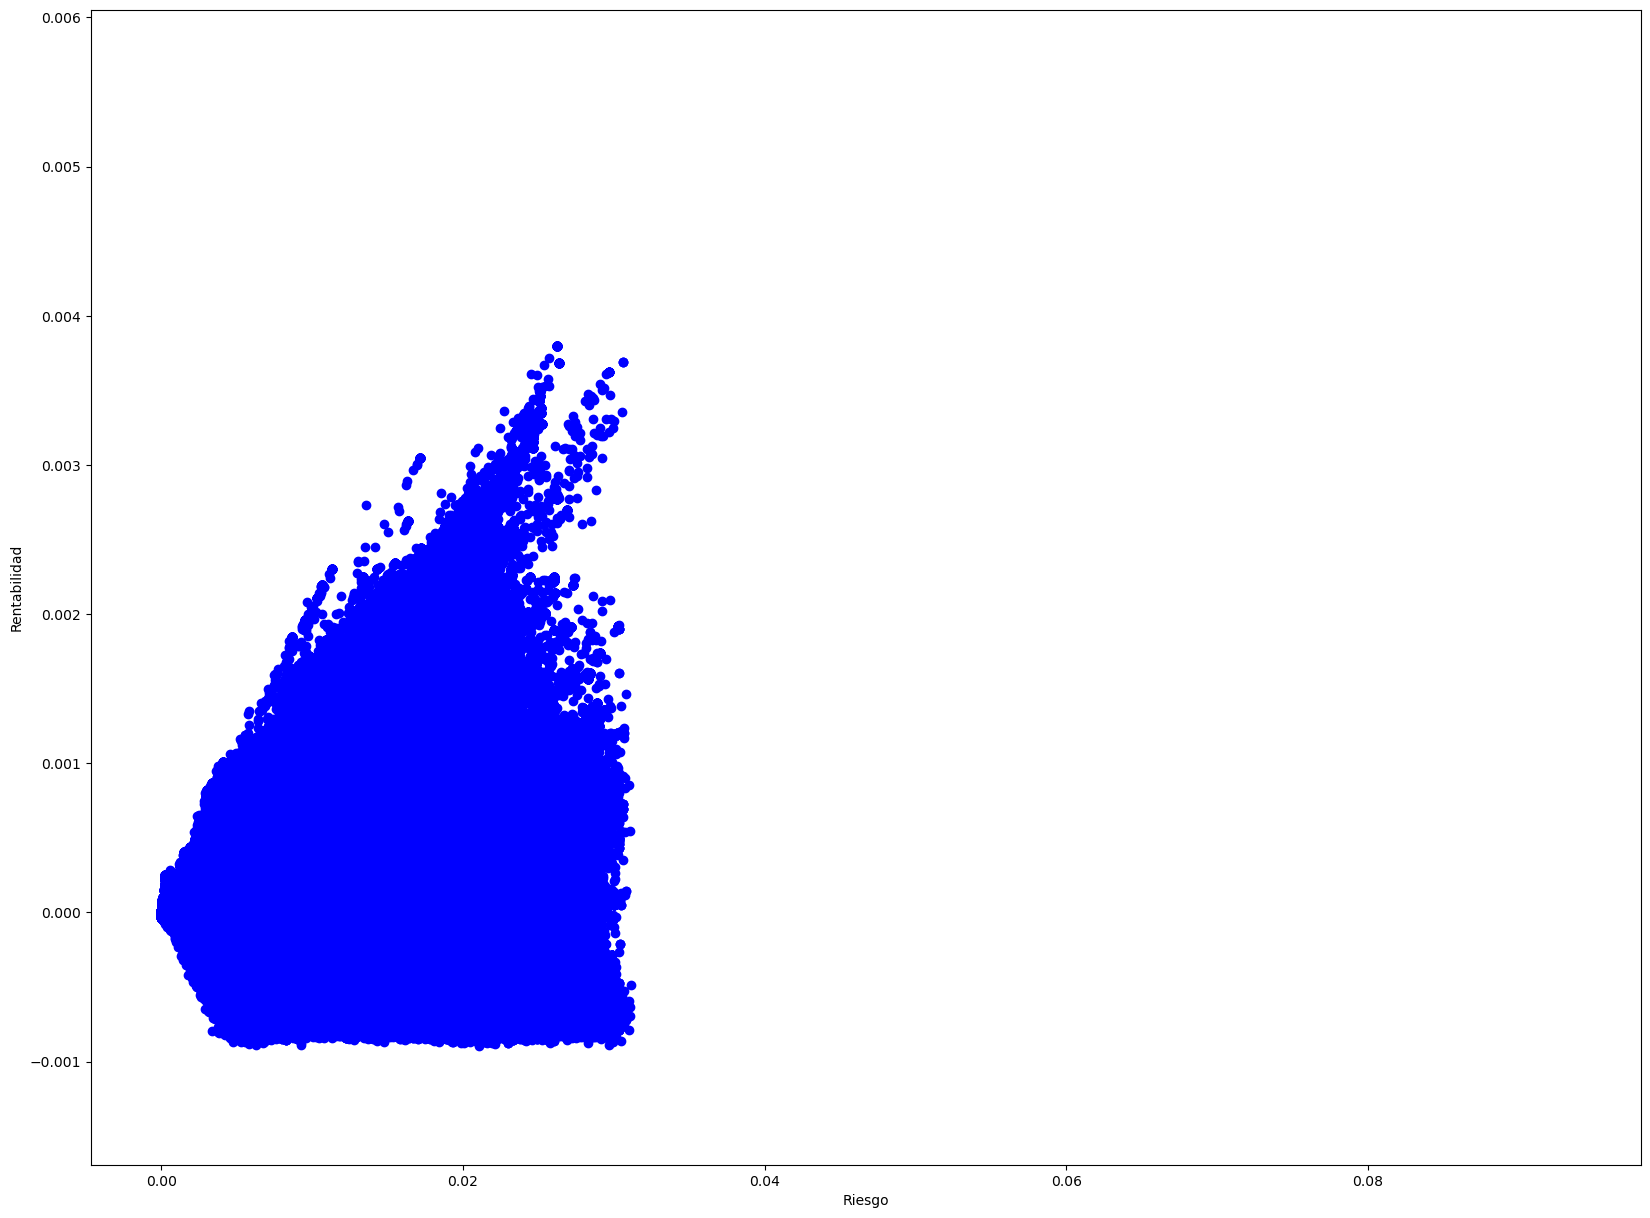

In [10]:
start_time = time()

isin_activos_eficientes, peso_activos_eficientes, max_eficiencia = frontera_markowitz(num_simulaciones = 5000000)

print(isin_activos_eficientes)
print(peso_activos_eficientes)
print(max_eficiencia)

elapsed_time = time() - start_time
print("")
print(elapsed_time)

In [ ]:

days = int(elapsed_time // (24 * 3600))
remaining_seconds = elapsed_time % (24 * 3600)


hours = int(remaining_seconds // 3600)
remaining_seconds = remaining_seconds % 3600


minutes = int(remaining_seconds // 60)


seconds = int(remaining_seconds % 60)

print(f'{days} días, {hours} horas, {minutes} minutos y {seconds} segundos')

0 días, 23 horas, 46 minutos y 29 segundos
